In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import calendar
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Optional: set matplotlib inline if using a Jupyter Notebook
%matplotlib inline

In [2]:
df = pd.read_csv('api_data/daily_cleaned3.csv')

df.set_index("Day", inplace= True)
df.index = pd.to_datetime(df.index)


df

,Total_consumption
Day,
2022-11-09,389.0860
2022-11-10,424.0817
2022-11-11,258.9267
2022-11-12,252.3417
2022-11-13,251.0023
...,...
2025-02-15,388.5460
2025-02-16,412.1156
2025-02-17,1101.3619


In [3]:
be_holidays = holidays.BE() 

def create_features(df):
    df = df.copy()
    
    df['day_of_week'] = df.index.dayofweek
    
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['is_festive'] = df.index.to_series().apply(lambda x: 1 if x in be_holidays else 0)
    
    df['is_summer'] = df.index.month.isin([6, 7, 8]).astype(int)
    df['is_winter'] = df.index.month.isin([12, 1, 2]).astype(int)
    # Cyclical features for day of week
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # Lagged features (avoid data leakage)
    df['consumption_lag_1d'] = df['Total_consumption'].shift(1)   # 1-day lag
    df['consumption_lag_7d'] = df['Total_consumption'].shift(7)   # 7-day lag
    
    # Additional lag features for monthly and yearly
    df['consumption_lag_30d'] = df['Total_consumption'].shift(30)   # Approx. monthly lag
    df['consumption_lag_365d'] = df['Total_consumption'].shift(365)   # Yearly lag
    
    # Advanced Lag Features
    df['consumption_lag_14d'] = df['Total_consumption'].shift(14)   # 14-day lag
    df['consumption_lag_21d'] = df['Total_consumption'].shift(21)   # 21-day lag
    df['rolling_avg_3d'] = df['Total_consumption'].rolling(window=3).mean()  # 3-day moving average
    df['rolling_std_3d'] = df['Total_consumption'].rolling(window=3).std()   # 3-day rolling standard deviation

    # Drop rows with NaN values resulting from lag features and rolling calculations
    df.dropna(inplace=True)
    
    return df

df = create_features(df)
df

,Total_consumption,day_of_week,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,is_festive,is_summer,...,day_of_week_sin,day_of_week_cos,consumption_lag_1d,consumption_lag_7d,consumption_lag_30d,consumption_lag_365d,consumption_lag_14d,consumption_lag_21d,rolling_avg_3d,rolling_std_3d
Day,,,,,,,,,,,,,,,,,,,,,
2023-11-09,678.0203,3,11,2023,313,9,45,0,0,0,...,0.433884,-0.900969,528.2885,563.0689,583.6545,389.0860,739.7156,511.0457,645.698133,105.046707
2023-11-10,589.2448,4,11,2023,314,10,45,0,0,0,...,-0.433884,-0.900969,678.0203,560.9567,610.3075,424.0817,496.8128,533.4916,598.517867,75.295387
2023-11-11,224.3303,5,11,2023,315,11,45,1,1,0,...,-0.974928,-0.222521,589.2448,254.2491,463.6771,258.9267,249.0253,254.1837,497.198467,240.443444
2023-11-12,230.2607,6,11,2023,316,12,45,1,0,0,...,-0.781831,0.623490,224.3303,250.0719,553.8337,252.3417,255.1903,261.5818,347.945267,208.992562
2023-11-13,473.0601,0,11,2023,317,13,46,0,0,0,...,0.000000,1.000000,230.2607,535.7822,233.7495,251.0023,624.6042,605.4853,309.217033,141.923237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-15,388.5460,5,2,2025,46,15,7,1,0,0,...,-0.974928,-0.222521,770.9813,365.0024,1036.7992,528.2334,384.0876,378.4498,873.394967,543.343575
2025-02-16,412.1156,6,2,2025,47,16,7,1,0,0,...,-0.781831,0.623490,388.5460,363.8366,1275.1537,324.6190,382.8140,414.2303,523.880967,214.319417
2025-02-17,1101.3619,0,2,2025,48,17,8,0,0,0,...,0.000000,1.000000,412.1156,1089.0754,413.4885,305.9155,1089.0018,1141.8606,634.007833,404.912027


C:\Users\user\AppData\Local\Temp\ipykernel_23520\46599113.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='Total_consumption', palette='Blues')


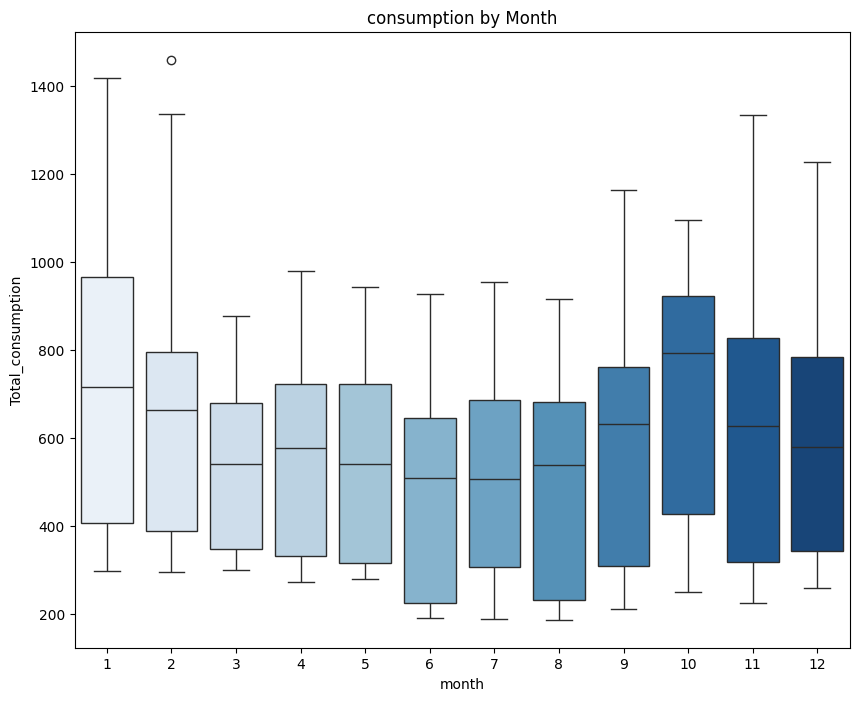

In [4]:
# viaualize the monthly Megawatt
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Total_consumption', palette='Blues')
ax.set_title('consumption by Month')
plt.show()

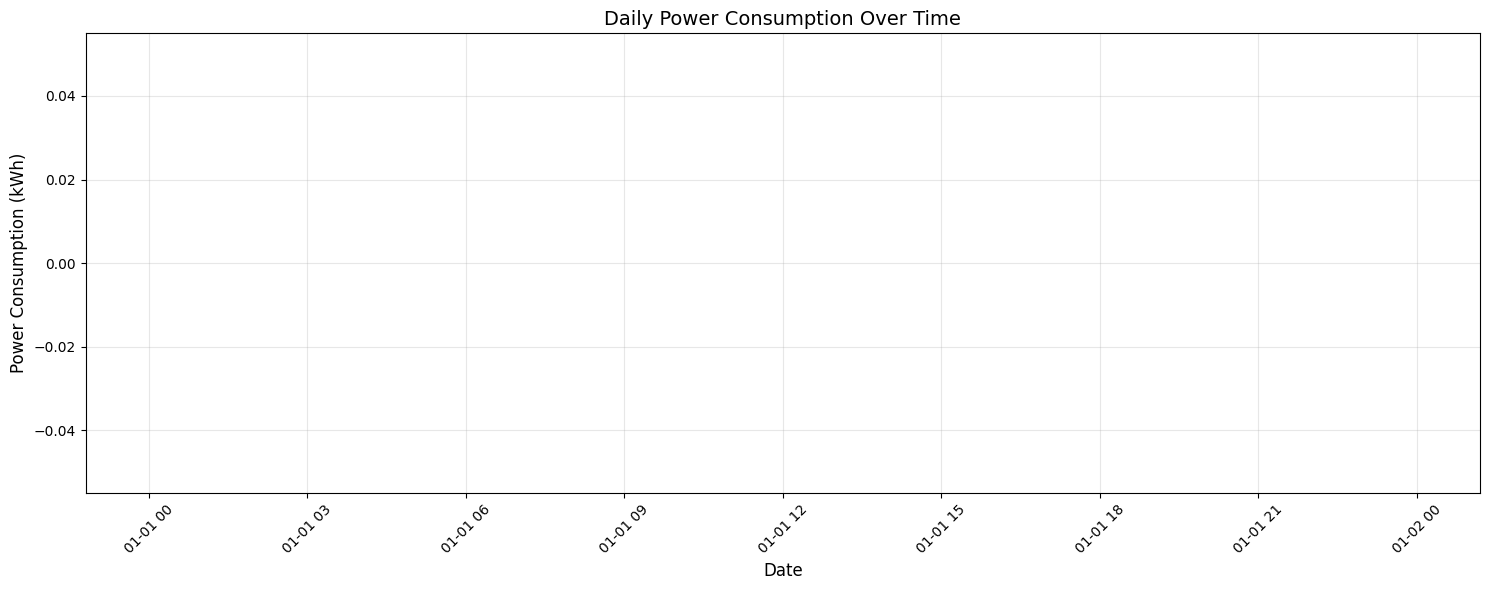

In [5]:
# Ensure the index is a DatetimeIndex first
df.index = pd.to_datetime(df.index)

# Filter the DataFrame by the date range
df_filtered = df.loc['2023-08-20 12:00:00':'2023-09-20 12:00:00']

plt.figure(figsize=(15, 6))
plt.plot(df_filtered.index, df_filtered['Total_consumption'], color='blue', alpha=0.6)
plt.title('Daily Power Consumption Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

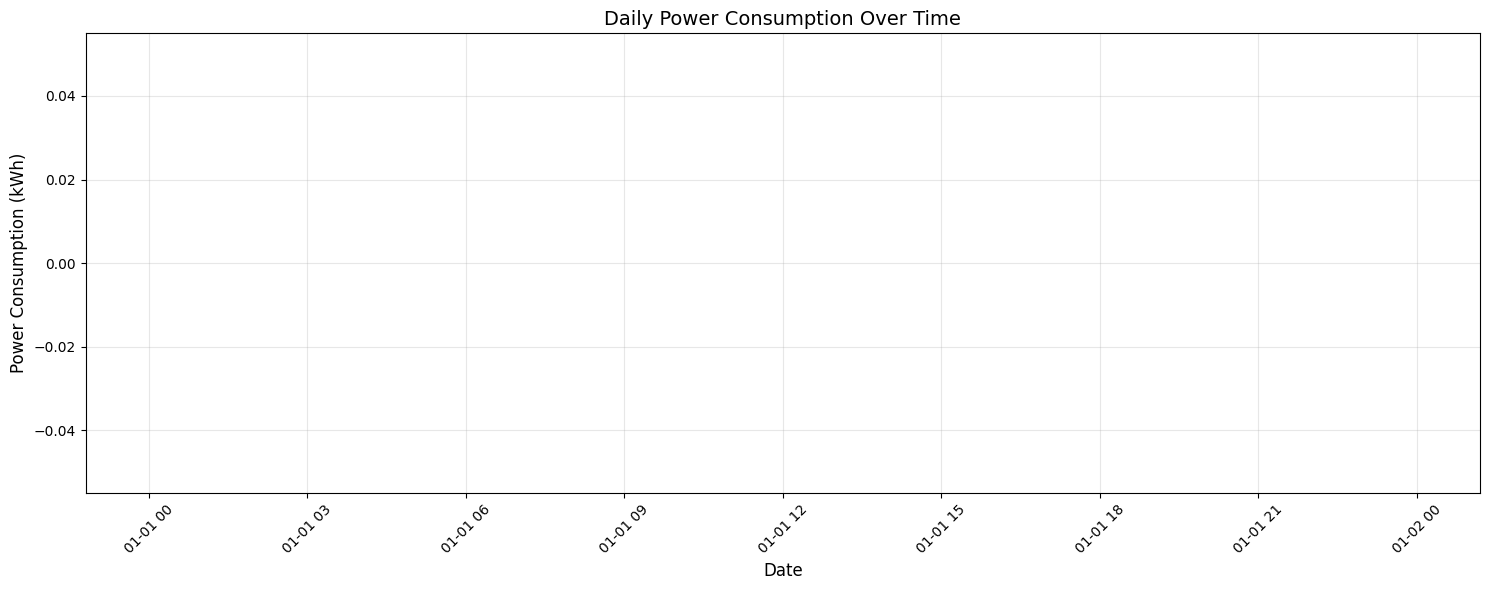

In [6]:
# Ensure the index is a DatetimeIndex first
df.index = pd.to_datetime(df.index)

# Filter the DataFrame by the date range
df_filtered_2 = df.loc['2022-09-15 12:00:00':'2022-11-08 12:00:00']

plt.figure(figsize=(15, 6))
plt.plot(df_filtered_2.index, df_filtered_2['Total_consumption'], color='blue', alpha=0.6)
plt.title('Daily Power Consumption Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Extract each time period separately
df_period1 = df.loc['2023-08-24 12:00:00':'2023-09-06 12:00:00']
df_period2 = df.loc['2022-10-15 12:00:00':'2022-11-08 12:00:00']

# Concatenate the two periods into one DataFrame
filtered_df = pd.concat([df_period1, df_period2])

df = df.drop(filtered_df.index)


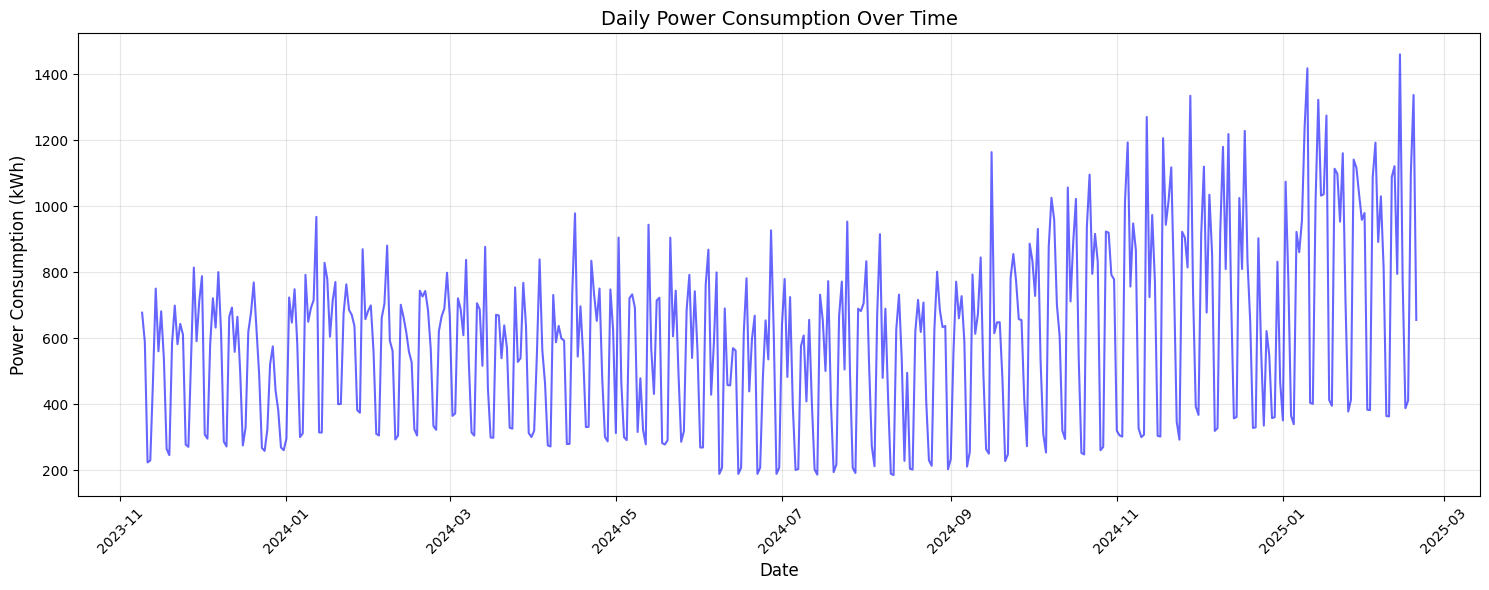

,Total_consumption,day_of_week,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,is_festive,is_summer,...,day_of_week_sin,day_of_week_cos,consumption_lag_1d,consumption_lag_7d,consumption_lag_30d,consumption_lag_365d,consumption_lag_14d,consumption_lag_21d,rolling_avg_3d,rolling_std_3d
Day,,,,,,,,,,,,,,,,,,,,,
2023-11-09,678.0203,3,11,2023,313,9,45,0,0,0,...,0.433884,-0.900969,528.2885,563.0689,583.6545,389.0860,739.7156,511.0457,645.698133,105.046707
2023-11-10,589.2448,4,11,2023,314,10,45,0,0,0,...,-0.433884,-0.900969,678.0203,560.9567,610.3075,424.0817,496.8128,533.4916,598.517867,75.295387
2023-11-11,224.3303,5,11,2023,315,11,45,1,1,0,...,-0.974928,-0.222521,589.2448,254.2491,463.6771,258.9267,249.0253,254.1837,497.198467,240.443444
2023-11-12,230.2607,6,11,2023,316,12,45,1,0,0,...,-0.781831,0.623490,224.3303,250.0719,553.8337,252.3417,255.1903,261.5818,347.945267,208.992562
2023-11-13,473.0601,0,11,2023,317,13,46,0,0,0,...,0.000000,1.000000,230.2607,535.7822,233.7495,251.0023,624.6042,605.4853,309.217033,141.923237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-15,388.5460,5,2,2025,46,15,7,1,0,0,...,-0.974928,-0.222521,770.9813,365.0024,1036.7992,528.2334,384.0876,378.4498,873.394967,543.343575
2025-02-16,412.1156,6,2,2025,47,16,7,1,0,0,...,-0.781831,0.623490,388.5460,363.8366,1275.1537,324.6190,382.8140,414.2303,523.880967,214.319417
2025-02-17,1101.3619,0,2,2025,48,17,8,0,0,0,...,0.000000,1.000000,412.1156,1089.0754,413.4885,305.9155,1089.0018,1141.8606,634.007833,404.912027


In [7]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Total_consumption'], color='blue', alpha=0.6)
plt.title('Daily Power Consumption Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
df

In [27]:
target = "Total_consumption"

exog_features = [
    "day_of_week_sin",
    "day_of_week_cos",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "is_weekend",
    "is_festive",
    
    "is_summer",
    "is_winter", 
    "consumption_lag_1d", 
    "consumption_lag_7d",
    "consumption_lag_30d", 
    "consumption_lag_365d", 
    "consumption_lag_14d", 
    "consumption_lag_21d",
    "rolling_avg_3d", 
    "rolling_std_3d"
]

y = df[target]
exog = df[exog_features]


<Figure size 1000x600 with 0 Axes>

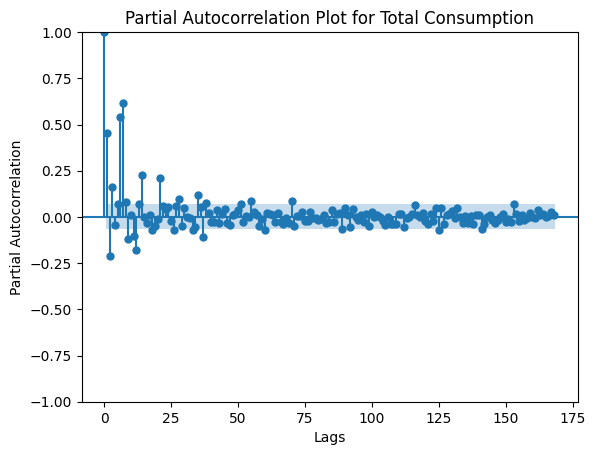

,Total_consumption,day_of_week,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,is_festive,is_summer,...,day_of_week_sin,day_of_week_cos,consumption_lag_1d,consumption_lag_7d,consumption_lag_30d,consumption_lag_365d,consumption_lag_14d,consumption_lag_21d,rolling_avg_3d,rolling_std_3d
Day,,,,,,,,,,,,,,,,,,,,,
2022-11-09,391.4783,2,11,2022,313,9,45,0,0,0,...,0.974928,-0.222521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-10,439.9409,3,11,2022,314,10,45,0,0,0,...,0.433884,-0.900969,391.4783,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-11,259.4419,4,11,2022,315,11,45,0,1,0,...,-0.433884,-0.900969,439.9409,NaN,NaN,NaN,NaN,NaN,363.620367,93.418524
2022-11-12,252.8694,5,11,2022,316,12,45,1,0,0,...,-0.974928,-0.222521,259.4419,NaN,NaN,NaN,NaN,NaN,317.417400,106.159340
2022-11-13,251.5286,6,11,2022,317,13,45,1,0,0,...,-0.781831,0.623490,252.8694,NaN,NaN,NaN,NaN,NaN,254.613300,4.235088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-15,388.5460,5,2,2025,46,15,7,1,0,0,...,-0.974928,-0.222521,770.9813,365.0024,1036.7992,568.9868,384.0876,378.4498,873.394967,543.343575
2025-02-16,412.1156,6,2,2025,47,16,7,1,0,0,...,-0.781831,0.623490,388.5460,363.8366,1275.1537,325.0870,382.8140,414.2303,523.880967,214.319417
2025-02-17,1101.3619,0,2,2025,48,17,8,0,0,0,...,0.000000,1.000000,412.1156,1089.0754,413.4885,306.3805,1089.0018,1141.8606,634.007833,404.912027


In [17]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Assume y is your target time series, e.g., from your dataframe:
y = df["Total_consumption"]

# Plot the Partial Autocorrelation Function (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(y, lags=168, method='ywm')  # Adjust the number of lags as needed
plt.title("Partial Autocorrelation Plot for Total Consumption")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation")
plt.show()

df

<Figure size 1000x600 with 0 Axes>

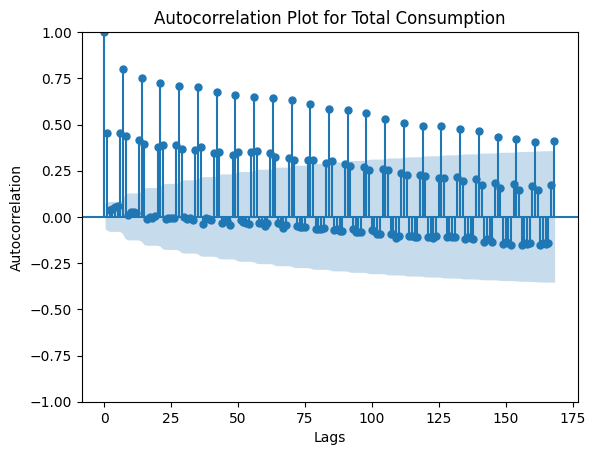

In [18]:
plt.figure(figsize=(10, 6))
plot_acf(y, lags=168)  # Adjust the lags as needed for your data
plt.title("Autocorrelation Plot for Total Consumption")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

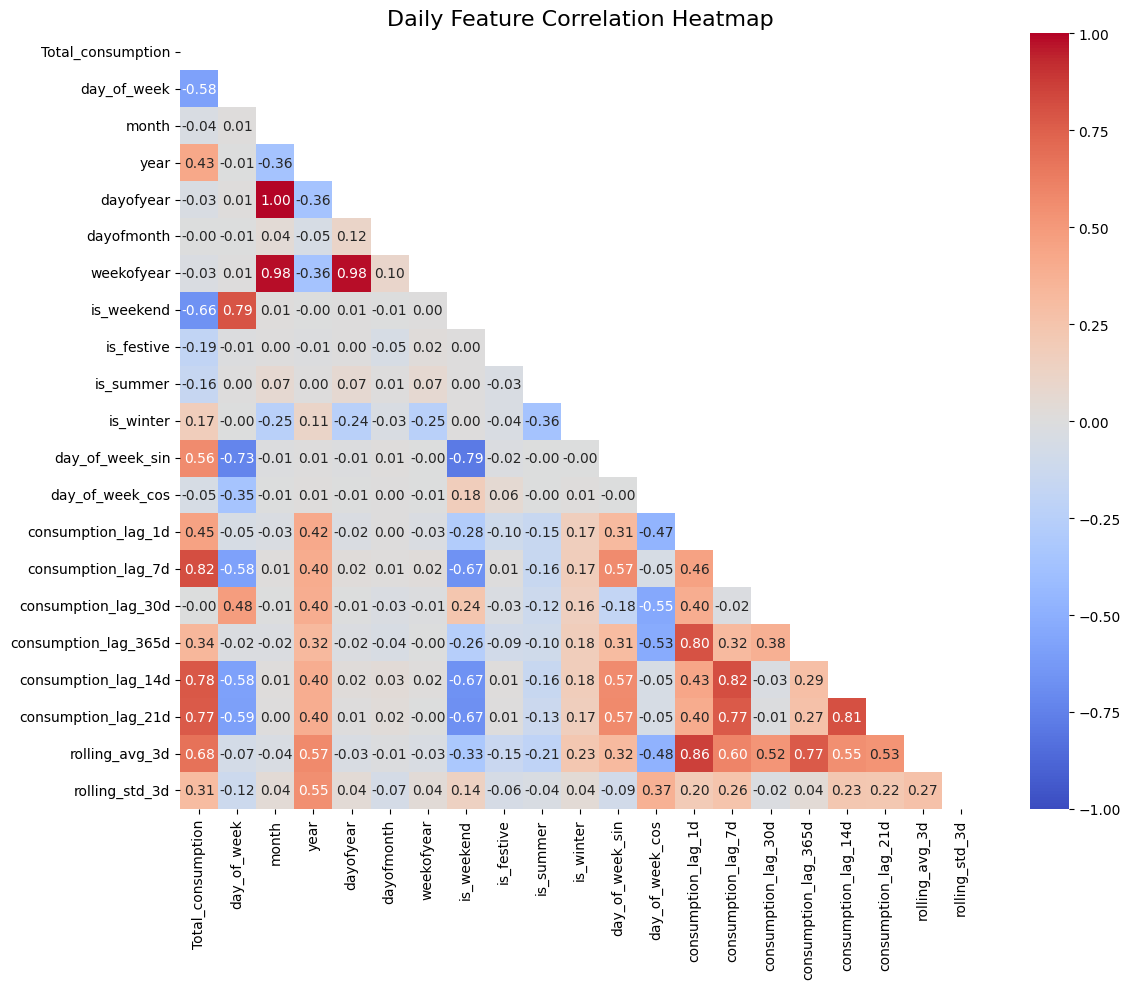

In [19]:
plt.figure(figsize=(12, 10))
numerical_features = df.select_dtypes(include=[np.number]).columns
correlation = df[numerical_features].corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, vmin=-1, vmax=1)
plt.title("Daily Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
print("\nBasic Statistics (Total Consumption):")
print(df['Total_consumption'].describe())


Basic Statistics (Total Consumption):
count     469.000000
mean      603.801717
std       269.547345
min       186.158800
25%       348.089400
50%       619.030700
75%       770.929200
max      1460.657600
Name: Total_consumption, dtype: float64


In [28]:
shift_val = abs(df["Total_consumption"].min()) + 1  
df["log_consumption"] = np.log(df["Total_consumption"] + shift_val)

In [29]:
target = "log_consumption"
y_orig = df["Total_consumption"]

y = df[target]
exog = df[exog_features]

In [30]:
split_index = int(0.80 * len(df))
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
exog_train, exog_test = exog.iloc[:split_index], exog.iloc[split_index:]
y_orig_train, y_orig_test = y_orig.iloc[:split_index], y_orig.iloc[split_index:]

print(f"Training data from {df.index[0].date()} to {df.index[split_index-1].date()}")
print(f"Testing data from {df.index[split_index].date()} to {df.index[-1].date()}")

Training data from 2023-11-09 to 2024-11-17
Testing data from 2024-11-18 to 2025-02-19


In [31]:
# Normalize the exogenous features using training data
scaler = StandardScaler()
exog_train_scaled = pd.DataFrame(
    scaler.fit_transform(exog_train),
    columns=exog_train.columns,
    index=exog_train.index
)
exog_test_scaled = pd.DataFrame(
    scaler.transform(exog_test),
    columns=exog_test.columns,
    index=exog_test.index
)

In [32]:
print("Finding optimal ARIMA parameters with limited search space...")
try:
    model_auto = auto_arima(
        y_train,
        exogenous=exog_train_scaled,
        seasonal=True,
        m=7,  # Weekly seasonality for daily data
        trace=True,
        error_action="ignore",
        suppress_warnings=True,
        stepwise=True,
        max_order=3,
        max_p=2,
        max_q=2,
        max_d=1,
        max_P=1,
        max_Q=1,
        max_D=1,
        start_p=1,
        start_q=1,
        start_P=1,
        start_Q=1,
        information_criterion='aic',
        maxiter=50,
        method='lbfgs',
        n_jobs=1
    )
    
    order = model_auto.order
    seasonal_order = model_auto.seasonal_order
    
    print("Optimal ARIMA order:", order)
    print("Optimal Seasonal order:", seasonal_order)
    
except Exception as e:
    print(f"Auto ARIMA failed with error: {e}")
    print("Using predefined ARIMA parameters instead...")
    order = (1, 1, 1)
    seasonal_order = (1, 0, 0, 7)

# ---------------------------
# Fit SARIMAX Model with a Constant Trend (Daily)
# ---------------------------
print("\nFitting SARIMAX model...")
try:
    model = SARIMAX(
        y_train,
        exog=exog_train_scaled,
        order=order,
        seasonal_order=seasonal_order,
        trend='c',  # Include a constant trend
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False, maxiter=200, method='lbfgs')
    
    print("\nModel Summary:")
    print(model_fit.summary().tables[0].as_text())
    print(model_fit.summary().tables[1].as_text())
    
    # Forecast on the log-transformed scale
    forecast_obj = model_fit.get_forecast(steps=len(y_test), exog=exog_test_scaled)
    y_pred_log = forecast_obj.predicted_mean
    y_pred_log.index = y_test.index

except MemoryError:
    print("Memory error during SARIMAX fitting. Using a simplified approach...")
    window_size = 2000
    y_pred_log = []
    for i in range(0, len(y_test), window_size):
        end_idx = min(i + window_size, len(y_test))
        subset_train = y_train.iloc[-10000:] if len(y_train) > 10000 else y_train
        subset_exog_train = exog_train_scaled.iloc[-10000:] if len(exog_train_scaled) > 10000 else exog_train_scaled
        
        subset_model = SARIMAX(
            subset_train,
            exog=subset_exog_train,
            order=(1, 1, 1),
            seasonal_order=(1, 0, 0, 7),
            trend='c',
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        subset_fit = subset_model.fit(disp=False, maxiter=100, method='lbfgs')
        subset_pred = subset_fit.get_forecast(
            steps=end_idx - i,
            exog=exog_test_scaled.iloc[i:end_idx]
        )
        y_pred_log.extend(subset_pred.predicted_mean.tolist())
    
    y_pred_log = pd.Series(y_pred_log, index=y_test.index)



Finding optimal ARIMA parameters with limited search space...
Performing stepwise search to minimize aic


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_

 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=-252.297, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=369.594, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=19.797, Time=0.15 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=76.850, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=367.602, Time=0.01 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.46 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=0.45 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=inf, Time=0.41 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.54 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=-143.410, Time=0.43 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[7] intercept   : AIC=-252.684, Time=0.63 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,1)[7] intercept   : AIC=33.229, Time=0.63 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=0.51 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=151.159, Time=0.32 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=-189.373, Time=0.59 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.19 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.84 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[7]             : AIC=-269.459, Time=0.52 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,1)[7]             : AIC=31.301, Time=0.21 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[7]             : AIC=inf, Time=0.54 sec
 ARIMA(2,1,1)(0,0,0)[7]             : AIC=149.312, Time=0.11 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[7]             : AIC=-270.797, Time=0.46 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[7]             : AIC=inf, Time=0.32 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[7]             : AIC=inf, Time=0.37 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[7]             : AIC=inf, Time=0.24 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[7]             : AIC=-272.698, Time=0.43 sec
 ARIMA(0,1,1)(0,0,1)[7]             : AIC=74.853, Time=0.12 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[7]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[7]             : AIC=262.981, Time=0.05 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,1)[7]             : AIC=-45.569, Time=0.17 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[7]             : AIC=-270.807, Time=0.53 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[7]             : AIC=-145.410, Time=0.24 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[7]             : AIC=inf, Time=0.45 sec

Best model:  ARIMA(0,1,1)(1,0,1)[7]          
Total fit time: 13.246 seconds
Optimal ARIMA order: (0, 1, 1)
Optimal Seasonal order: (1, 0, 1, 7)

Fitting SARIMAX model...


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Model Summary:
                                     SARIMAX Results                                     
Dep. Variable:                   log_consumption   No. Observations:                  375
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood                 302.570
Date:                           Mon, 17 Mar 2025   AIC                           -557.139
Time:                                   13:28:39   BIC                           -463.542
Sample:                               11-09-2023   HQIC                          -519.942
                                    - 11-17-2024                                         
Covariance Type:                             opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept                0.0002      0.008      0.026      0.980      -0.016       0.0

In [33]:
# ---------------------------
# Invert the Log Transformation (Daily)
# ---------------------------
y_pred = np.exp(y_pred_log) - shift_val

In [34]:
# ---------------------------
# Compute Performance Metrics on Original Scale
# ---------------------------
def calculate_mape(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def calculate_smape(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred) + 1e-10
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / denominator)

mae = mean_absolute_error(y_orig_test, y_pred)
mse = mean_squared_error(y_orig_test, y_pred)
rmse = np.sqrt(mse)
mape = calculate_mape(y_orig_test.values, y_pred.values)
smape = calculate_smape(y_orig_test.values, y_pred.values)
r2 = r2_score(y_orig_test, y_pred)

print("\nModel Performance Metrics (Original Scale):")
print(f"MAE:   {mae:.4f}")
print(f"MSE:   {mse:.4f}")
print(f"RMSE:  {rmse:.4f}")
print(f"MAPE:  {mape:.4f}%")
print(f"sMAPE: {smape:.4f}%")
print(f"R²:    {r2:.4f}")


Model Performance Metrics (Original Scale):
MAE:   169.9309
MSE:   59669.8612
RMSE:  244.2742
MAPE:  24.1237%
sMAPE: 19.7399%
R²:    0.4589


In [35]:
# ---------------------------
# Create Forecast DataFrame and Save Predictions (Daily)
# ---------------------------
forecast_df = pd.DataFrame({
    "Real_Consumption_kWh": y_orig_test,
    "Predicted_Consumption_kWh": y_pred
}, index=y_orig_test.index)

forecast_df["Difference"] = forecast_df["Predicted_Consumption_kWh"] - forecast_df["Real_Consumption_kWh"]
forecast_df["Absolute_Error"] = abs(forecast_df["Difference"])
forecast_df["Percent_Error"] = (forecast_df["Absolute_Error"] / (forecast_df["Real_Consumption_kWh"].abs() + 1e-10)) * 100
forecast_df = forecast_df.round(4)
forecast_df.to_csv("results/daily3/predicted_values_kwh.csv")
print("\nPredicted values have been saved to 'results/daily3/predicted_values_kwh.csv'")


Predicted values have been saved to 'results/daily3/predicted_values_kwh.csv'


In [36]:
# ---------------------------
# Feature Importance Analysis (Daily)
# ---------------------------
feature_importance = pd.DataFrame({
    'Feature': exog_features,
    'Correlation': [abs(df[feature].corr(df[target])) for feature in exog_features]
})
feature_importance = feature_importance.sort_values('Correlation', ascending=False)
print("\nFeature Importance by Correlation with Target (Log Scale):")
print(feature_importance.head(10))
feature_importance.to_csv("results/daily3/feature_importance.csv", index=False)


Feature Importance by Correlation with Target (Log Scale):
                 Feature  Correlation
7             is_weekend     0.817128
12    consumption_lag_7d     0.796897
15   consumption_lag_14d     0.756668
16   consumption_lag_21d     0.742406
0        day_of_week_sin     0.686927
17        rolling_avg_3d     0.596371
11    consumption_lag_1d     0.374002
14  consumption_lag_365d     0.335181
8             is_festive     0.225736
9              is_summer     0.222002


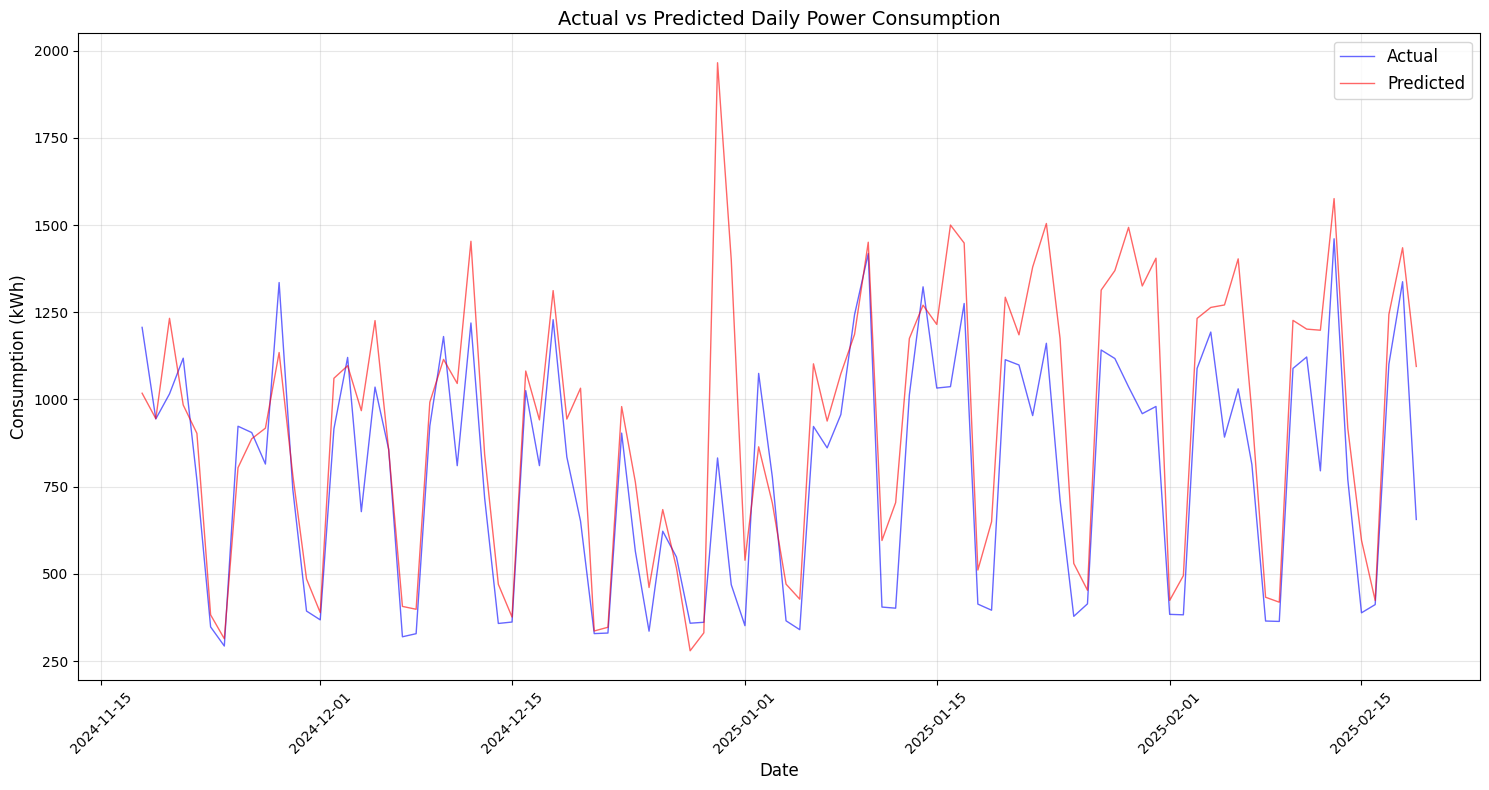

In [37]:
# ---------------------------
# Visualization: Forecast Comparison (Daily)
# ---------------------------
plt.figure(figsize=(15, 8))
plt.plot(forecast_df.index, forecast_df["Real_Consumption_kWh"], label="Actual", color="blue", alpha=0.6, linewidth=1)
plt.plot(forecast_df.index, forecast_df["Predicted_Consumption_kWh"], label="Predicted", color="red", alpha=0.6, linewidth=1)
plt.title("Actual vs Predicted Daily Power Consumption", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Consumption (kWh)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




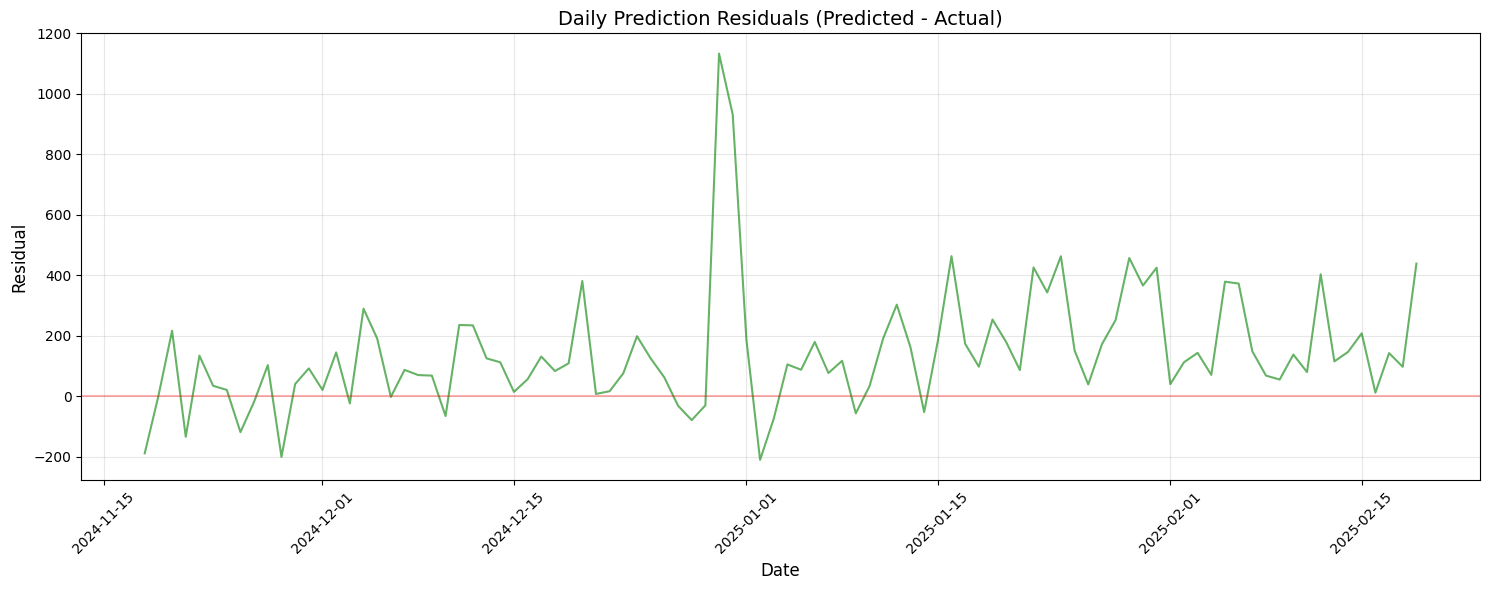

In [38]:
# Plot the residuals
plt.figure(figsize=(15, 6))
plt.plot(forecast_df.index, forecast_df["Difference"], color='green', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title("Daily Prediction Residuals (Predicted - Actual)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Residual", fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [ ]:
# Plot error distribution
plt.figure(figsize=(10, 6))
plt.hist(forecast_df["Difference"], bins=30, alpha=0.7, color='skyblue')
plt.title("Distribution of Daily Prediction Errors", fontsize=14)
plt.xlabel("Prediction Error", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




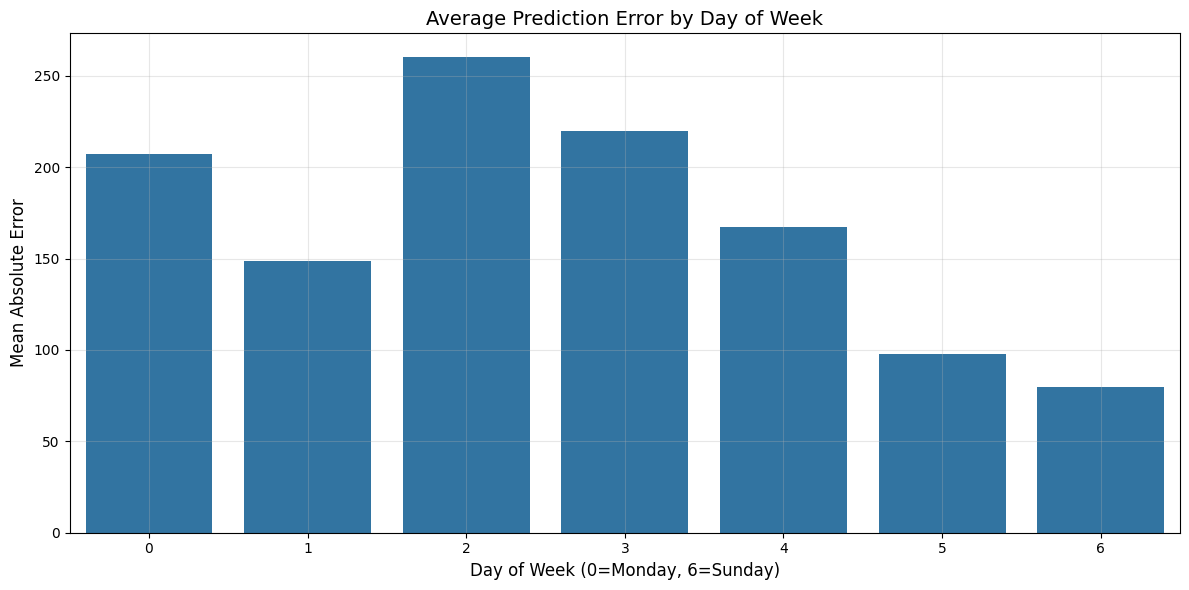


All daily visualizations have been saved in the 'results/daily3' directory.
Daily forecasting analysis complete.


In [39]:
# Remove index name to avoid ambiguity when grouping
forecast_df.index.name = None

# Add additional column for error analysis: day_of_week
forecast_df['Day_of_Week'] = forecast_df.index.dayofweek

# Error by day of week
plt.figure(figsize=(12, 6))
day_error = forecast_df.groupby('Day_of_Week')['Absolute_Error'].mean()
sns.barplot(x=day_error.index, y=day_error.values)
plt.title('Average Prediction Error by Day of Week', fontsize=14)
plt.xlabel('Day of Week (0=Monday, 6=Sunday)', fontsize=12)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


print("\nAll daily visualizations have been saved in the 'results/daily3' directory.")
print("Daily forecasting analysis complete.")



In [ ]:
# ---------------------------
# Boxplot: Comparison of Real vs Forecasted Values
# ---------------------------
# Melt the DataFrame to convert it into a long format suitable for a boxplot.
melted_df = forecast_df[['Real_Consumption_kWh', 'Predicted_Consumption_kWh']].reset_index().melt(
    id_vars='index', 
    value_vars=['Real_Consumption_kWh', 'Predicted_Consumption_kWh'],
    var_name='Type',
    value_name='Consumption'
)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Consumption', data=melted_df)
plt.title("Comparison of Real vs Forecasted Daily Consumption")
plt.xlabel("Consumption Type")
plt.ylabel("Daily Consumption (kWh)")
plt.tight_layout()
plt.show()